<!-- dom:TITLE: A practical introduction to sensitivity analysis -->
# A practical introduction to sensitivity analysis
<!-- dom:AUTHOR: Leif Rune Hellevik at Department of Structural Engineering, NTNU -->
<!-- Author: --> **Leif Rune Hellevik**, Department of Structural Engineering, NTNU

Date: **Jan 25, 2017**

In [12]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import chaospy as cp
from numpy import linalg as LA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction
labe{sec:introduction}

This practical introduction to sensitivity analysis is based on the
presentation and examples found in [[saltelli_global_2008]](#saltelli_global_2008). To give
the reader an even better hands on expericence of the topic, we have
integrated the computations in a python notebook format.

Many sensitivity anlyses reported in the literature are based on
derviatives at set point or point of interest. Indeed such apporaches
are based on the fact that the derivative of $\partial Y_i/\partial
X_j$ of quantity of interest $Y_i$ as a function of an input variable
$X_j$ can be thought of as the mathematical definition of the
sensitivity of $Y_i$ versus $X_j$.

However, what is important to keep in mind is that local derivatives
are only informative at the set point in the parameter space at which
they are computed, and do not provide information for the rest of the
parameter space. Naturally, such a linearization will matter little
for linear models, but for general, nonlinear models, care must be
taken.  In particular this is important in situations when the input
parameters are uncertain.

We will therefore make use of methods based on the exploration of the
input parameter space by judiciously selecting samples in that space,
which will result in more robust an informative sensitivity measures,
than what result from a local derivative at the center of the
parameter space.

However, to introduce the methods of sensitivity analysis, we shall
start from derivatices and illustrate them on a very simple linear
model.

# A simple linear model

As an simple linear model example consider:

<!-- Equation labels as ordinary links -->
<div id="eq:linear_model"></div>

$$
\begin{equation}
Y = \sum_{i=1}^{r} \Omega_i \, Z_i
\label{eq:linear_model} \tag{1}
\end{equation}
$$

where the input factors are $\mathbf{X} = (\Omega_1, \Omega_2, \ldots,
\Omega_r, Z_1, Z_2, \ldots, Z_r)$. For simplicity we assume that the
model output $Y$ of [(1)](#eq:linear_model) is a single variable and
that the $\Omega s$ are fixed coefficients or weights.

$$
\begin{equation}
 \Omega_1=\Omega_2=\ldots=\text{constant}
\end{equation}
$$

Consequently, the true factors of [(1)](#eq:linear_model) are just
$(Z_1, Z_2, \ldots, Z_r)$. The individual variables
$Z_i$ are taken to normally distributed with mean zero

<!-- Equation labels as ordinary links -->
<div id="eq:NZi"></div>

$$
\begin{equation} Z_i \sim N(0, \sigma_{Z_i}), \qquad i=1,2, \ldots, r
\label{eq:NZi} \tag{2} \end{equation}
$$

As the predicted value $Y$ of the model in [(1)](#eq:linear_model) is
linear combination of normally distributed factors, it is easy to
verify (see exercices in [[saltelli_global_2008]](#saltelli_global_2008)) that $Y$ also will
be normally distributed with:

<!-- Equation labels as ordinary links -->
<div id="eq:analytic_mean_std"></div>

$$
\begin{equation}
\bar{y} = \sum_{i=1}^{r} \Omega_i \; \bar{z}_i, \qquad \sigma_Y = \sqrt{\sum_{i=1}^{r} \Omega_i^2 \, \sigma_{Z_i}^2}
\label{eq:analytic_mean_std} \tag{3}	
\end{equation}
$$

Furthermore, we order the factors from the most certain to the less
certain, i.e.:

$$
\begin{equation}
 \sigma_{Z_1} <  \sigma_{Z_2} <  \ldots  <  \sigma_{Z_r}
\label{}
\end{equation}
$$

# Scatterplots versus derivatives

We have implemented the simple linear model in [(1)](#eq:linear_model) in python as:

In [13]:
#  The linear model
def linear_model(w,Z,N):
    Y=np.zeros(N)
    if (w.size>1):
        for i in range(len(w)):
            Y[:]+=w[i]*Z[i,:]
    else:
        Y=w*Z

    return Y

To hold the mean and the standard deviation of all the input factors
we use a numpy-array of size $r\times 2$, with one row per factor,
where the first column holds the mean whereas the second column holds
the standard deviation. The weights $\Omega_{1\ldots r}$ are stored in a numpy-vector.

In [14]:
# Set mean (column 0) and standard deviations (column 1) for each factor z. r factors=nr. rows
r=4 # number of factors 
zm=np.zeros((r,2))
zm[0,1]=1
zm[1,1]=2
zm[2,1]=3
zm[3,1]=4

# Set the weigth
wc=2
w=np.ones(r)*wc

We may now perform a Monte Carlo experiment on our model by generating $N$ samples from the distributions of each factor and an input sample is thus produced:

<!-- Equation labels as ordinary links -->
<div id="eq:mc_sample"></div>

$$
\begin{equation}
\mathbf{Z} = \left [
\begin{array}{cccc}
Z_{1,1} & Z_{1,2}  & \ldots & Z_{1,N} \\
Z_{2,1} & Z_{2,2}  & \ldots & Z_{2,N}\\
\vdots & \vdots & \vdots & \vdots \\
Z_{r,1} & Z_{r,2}  & \ldots & Z_{r,N}
\end{array} 
\right ]
\label{eq:mc_sample} \tag{4}
\end{equation}
$$

We may the compute a value of $Y$ from [(1)](#eq:linear_model) for each
column in [(4)](#eq:mc_sample) to produce a solution vector
$\mathbf{Y}$. Having sampled $N$ values from each input factor we may
produce $r$ scatter plots, by projecting in turn the $N$ values of
$\mathbf{Y}$ against the $N$ values of each of the $r$ input factors.

<!-- Equation labels as ordinary links -->
<div id="eq:mc_solution"></div>

$$
\begin{equation}
\mathbf{Y} = \left [
\begin{array}{c}
y_1 \\
y_2 \\
\vdots \\
y_N
\end{array}
\right ]
\label{eq:mc_solution} \tag{5}
\end{equation}
$$

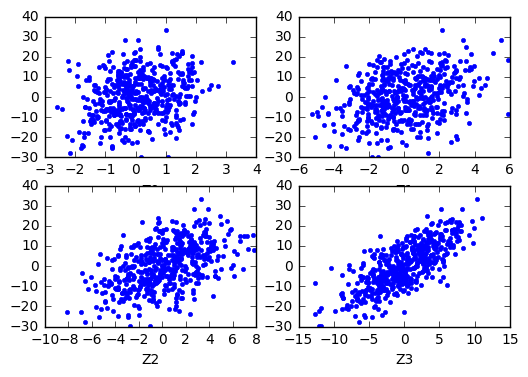

In [15]:
# Genrate distributions for each element in z
N=500
Z=np.zeros(shape=(r,N))
pdf=[]
for i, z in enumerate(zm):
    pdf.append(cp.Normal(z[0],z[1]))
    Z[i,:]=pdf[i].sample(N)

Y = linear_model(w,Z,N)

# Scatter plots of data for visual inspection of sensitivity 
plt.figure()
for k in range(r):
    plt.subplot(2,2,k+1)
    plt.plot(Z[k,:],Y[:],'.')
    xlbl='Z'+str(k)
    plt.xlabel(xlbl)

Note that the assumption of independent factors $Z_i$, we may sample
each $Z_i$ independently from their marginal distributions and store
all the samples for all the factors $Z_i$ in the the numpy array
'Z[i,:]', where $i$ corresponds to $Z_i$ as:

        pdf.append(pc.Normal(z[0],z[1]))
            Z[i,:]=pdf[i].sample(N)


From the scatterplots generated by the python code above we
intuitively get the impression that $Y$ is more sensitive to $Z_4$
than to $Z_3$, and that $Y$ is more sensitive to $Z_3$ than to $Z_3$,
and that we may order the factors my influence on $Y$ as:

<!-- Equation labels as ordinary links -->
<div id="eq:scatter_plot_rank"></div>

$$
\begin{equation}
Z_4 > Z_3 > Z_2 > Z_1 
\label{eq:scatter_plot_rank} \tag{6}
\end{equation}
$$

Our intuitive notion of influence is based on that there is more shape
(or better pattern) in the plot for $Z_4$ than for $Z_3$ and likewise.

For our simple linear model in [(1)](#eq:linear_model) we are in the
fortunate situation that we may compute the local derivatives analyticaly:

<!-- Equation labels as ordinary links -->
<div id="eq:Sp"></div>

$$
\begin{equation}
S_{Z_i}^{p} = \frac{\partial Y}{\partial Z_i} = \Omega_i
\label{eq:Sp} \tag{7}
\end{equation}
$$

In our code example we set all the $\Omega_i=2$ for $i=1,\ldots,4$,
and according to the local sensitivity meansure $S_{Z_i}^{p}$ in
[(7)](#eq:Sp) all the input factors $Z_i$s are equally important and
independent of the variation of each factor. This measure is clearly
at odds with the ranking of influence based on the scatterplots in
[(6)](#eq:scatter_plot_rank) and is an indication of the usefullness of
scatterplots in sensititivy analysis. However, the bidimensional
scatterplots may in some cases be deceiving and lead to type II
errors (i.e. failure to identify influential parameters). ref to Saltelli 2004...

Most sensitivity measures aim to preserve the rich information
provided by the scatterplots in a condensed format. The challenge is
how to rank the factors rapidly and automatically without having to
inspect many scatterplots in situations with many input
factors. Another challenge with scatterplots is that sensitivities for
sets cannot be visualized, while luckily compact sensitivity measures may be
defined in such cases.

# Normalized derivatives and standardized regression coefficients

## Normalized derivatives
A simple way to improve the derivative sensitivity measure $S_{Z_i}^{p}$ in
[(7)](#eq:Sp) is to scale the input-output variables with their standard deviations:

<!-- Equation labels as ordinary links -->
<div id="eq:Ss"></div>

$$
\begin{equation}
S_{Z_i}^{\sigma} = \frac{\partial Y/\sigma_Y}{\partial Z_i/\sigma_{Z_i}} = \frac{\sigma_{Z_i}}{\sigma_{Y}} \; \frac{\partial Y}{\partial Z_i}
\label{eq:Ss} \tag{8}
\end{equation}
$$

In case of our simple linear model [(1)](#eq:linear_model) we get from
[(8)](#eq:Ss):

<!-- Equation labels as ordinary links -->
<div id="eq:Ss_simple"></div>

$$
\begin{equation}
\left (S_{Z_i}^{\sigma} \right)^2 = \left( \frac{\sigma_{Z_i}}{\sigma_{Y}}\right)^2 \; \left (\frac{\partial Y}{\partial Z_i}\right)^2 = \left( \frac{\sigma_{Z_i}\, \Omega_i}{\sigma_{Y}}\right)^2 \;  \qquad \textsf{which may be rearranged to:} \qquad \sigma_y^2 \, (S_{Z_i}^{\sigma})^2 = \left ( \Omega_{i} \sigma_{Y} \right )^2
\label{eq:Ss_simple} \tag{9}
\end{equation}
$$

Based on the linearity of our model we previously found  [(3)](#eq:analytic_mean_std) which also yields:

<!-- Equation labels as ordinary links -->
<div id="eq:Ss_model_ded"></div>

$$
\begin{equation}
 \sigma_Y^2 = \sum_{i=1}^{r} \left(\Omega_i^2 \, \sigma_{Z_i}\right)^2
 \label{eq:Ss_model_ded} \tag{10}
\end{equation}
$$

As both [(10)](#eq:Ss_model_ded) and [(9)](#eq:Ss_simple) must hold simultaneously we get

<!-- Equation labels as ordinary links -->
<div id="eq:Ss1"></div>

$$
\begin{equation}
\left (S_{Z_i}^{\sigma} \right)^2=1 
\label{eq:Ss1} \tag{11}
\end{equation}
$$

The normalized derivative measure of sensitivity in [(8)](#eq:Ss) is
more convincing than [(7)](#eq:Sp): first, as it involves both the
weights $\Omega_i$ and the factors $Z_i$ in [(1)](#eq:linear_model);
second as the measures are properly scaled and summarizes to one,
which allows for an easy interpretation of the output sensitivity with
respect to each of the input factors.

In [16]:
#  Theoretical sensitivity indices
s_y=np.sqrt(np.sum((w*zm[:,1])**2))
print 's_y=',s_y

s=w*zm[:,1]/s_y
print 's=',s, ',   norm(s)=',LA.norm(s)
print 's^2=',s**2

s_y= 10.9544511501
s= [ 0.18257419  0.36514837  0.54772256  0.73029674] ,   norm(s)= 1.0
s^2= [ 0.03333333  0.13333333  0.3         0.53333333]


Based on our samples from our samples of the input factors and the
subsequent model evaluations, we may estimate the standard deviation
of $\mathbf{Y}$ and compute the relative error with respect to the
theoretical value. You may change the number of sample above,
i.e. $N$, and see how $N$ influence the estimates.

In [17]:
#  Sensitivity indices based on sampled values
print 'std(Y)=',np.std(Y, 0), '  rel.err=', (np.std(Y, 0)-s_y)/s_y
print np.mean(Y,0), np.sqrt(np.var(Y,0))

std(Y)= 11.2680074482   rel.err= 0.0286236429234
0.324267971801 11.2680074482


Note that $N$ is the size of our Monte Carlo experiment, corresponding
to the number of times we have evaluated our simple linear model
[(1)](#eq:linear_model). The evaluation of the model is normally the
most computationally expensive part of the analysis, and for that
reasons $N$ is referred to as the 'cost' of the analysis.

## Linear regression

The most popular way of trying to condense the information provided by scatter plots is to try a multiple linear regression:

<!-- Equation labels as ordinary links -->
<div id="eq:meta_model"></div>

$$
\begin{equation}
\hat{Y}_j = b_0 + \sum_{i=1}^{r} b_j \, Z_{i,j}
\label{eq:meta_model} \tag{12}
\end{equation}
$$

where the coefficients $b_0$ and $b_j$ are found my least-square
minimization of the squared differences between the predicted
hat-values $\hat{Y}_j$ from the meta-model [(12)](#eq:meta_model) and
the actual model output $Y_j$ produced by the Monte-Carlo simulation:

<!-- Equation labels as ordinary links -->
<div id="eq:lsm"></div>

$$
\begin{equation}
SS = \sum_{j=1}^{N} \left (Y_j - \hat{Y}_j \right)^2  =  \sum_{j=1}^{N} \left (Y_j -\left (b_0 + \sum_{i=1}^{r} b_j \, Z_{i,j} \right ) \right)^2 
\label{eq:lsm} \tag{13}
\end{equation}
$$

As we have generated all the $Y_j$s by a linear model
[(1)](#eq:linear_model), which has been feed with the Monte-Carlo
samples [(4)](#eq:mc_sample), we excpect that a successfull multiple
linear regression analysis will rediscover the original linear model,
i.e. $\hat{b}_0 \cong 0$ and $\hat{b}_i \cong \Omega_i$ for $i=1,
\ldots, r$, where the hats denote estimates and $\cong$ means the
value which the estimate will converge to the the samples size $N$ is
large enough.

[Statsmodels](http://statsmodels.sourceforge.net/) is a Python
module that allows users to explore data, estimate statistical models,
perform statistical tests, and multiple regression analysis. An extensive list of descriptive
statistics, statistical tests, plotting functions, and result
statistics are available for different types of data and each estimator.

Below we have illustrated how such a conventional multiple regression analysis may be carried out with the Statmodels module.

In [18]:
#  Standard Multivariate Regression
import statsmodels.api as sm

results = sm.OLS(Y, Z.T).fit()
w_ols=results.params  #weights from ordinary least squares
print results.summary()
print 'Regression coefficients',w_ols
print 'Rel.error for coefficients:', (w_ols-w)/w
# fig=plt.figure(figsize=(12,8))
# fig = sm.graphics.plot_partregress_grid(results, fig=fig)
# fig = plt.figure(figsize=(12, 8))
# fig = sm.graphics.plot_ccpr_grid(results, fig=fig)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.506e+31
Date:                Wed, 25 Jan 2017   Prob (F-statistic):               0.00
Time:                        18:25:43   Log-Likelihood:                 15146.
No. Observations:                 500   AIC:                        -3.028e+04
Df Residuals:                     496   BIC:                        -3.027e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             2.0000   7.66e-16   2.61e+15      0.0

Observe in the 'coef' column of the summary generated by Statmodels,
the values for the coefficients corresponding to $b_i$ in
[(12)](#eq:meta_model) are listed, we have also computed the relative
error of these coefficients with respect to the analytical weights
$\Omega_i$ in [(1)](#eq:linear_model). You may explore how how the
relative error changes with the number of samples $N$.


However, more widely used than the raw regression coeffients are their
normalized equivalents, often referred to as standardized regression
coefficients (SRCs): $\hat{\beta_i}= \hat{b}_i
\,\sigma_{Z_i}/\sigma_Y$. And for our simple linear model
[(1)](#eq:linear_model) we will get the following for a large enough
$N$:

<!-- Equation labels as ordinary links -->
<div id="eq:src"></div>

$$
\begin{equation}
\hat{\beta_i}= \frac{\hat{b}_i \, \sigma_{Z_i}}{\sigma_Y} \cong \frac{\Omega_i \, \sigma_{Z_i}}{\sigma_Y} 
\label{eq:src} \tag{14}
\end{equation}
$$

which by comparison with our previous expression for the normalized derivatives in [(8)](#eq:Ss) we get:

$$
\begin{equation}
\hat{\beta}_i = S_{Z_i}^{\sigma} \qquad \textsf{for the linear models only}
\label{}
\end{equation}
$$

and consequelty we get from [(11)](#eq:Ss1):

<!-- Equation labels as ordinary links -->
<div id="eq:sum_beta"></div>

$$
\begin{equation}
 \sum_{i=1}^{r} \beta_i^2 = 1
\label{eq:sum_beta} \tag{15}
\end{equation}
$$

Here we state without proof that the standardized regression coeffients (SRCs)
may be obtained by an ordinary least squares approach when the
variables involved have been [z-score transformed](https://en.wikipedia.org/wiki/Standard_score). The z-score
transformation is also commonly referred to as z-values, z-scores,
normal scores, and standardized variables, and is obtained by
subtraction of the mean and division of the standard deviation.


In the code example below we use the z-score transformation from
'scipy', and by performing the standard multiple regression on the
transformed factors we get the SRCs in the column 'coef'. The SRCs are
stored in the 'res_standardize.params' which we assign to 'src', which
allows for direct comparison with the previously computed with the clause:

        print 'Rel. error SRC', (beta**2-s**2)/s**2 


You may experiment with the number of sample values $N$ to see how it influences the relative error.

In [19]:
# Scale the variables to obtain standardized regression coefficients (SRC)
from scipy.stats.mstats import zscore
res_standardize=sm.OLS(zscore(Y), zscore(Z.T)).fit()
print res_standardize.summary() 
beta = res_standardize.params
print '\nSRCs:', beta**2
print 'Rel. error SRC', (beta**2-s**2)/s**2

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.216e+32
Date:                Wed, 25 Jan 2017   Prob (F-statistic):               0.00
Time:                        18:25:44   Log-Likelihood:                 16963.
No. Observations:                 500   AIC:                        -3.392e+04
Df Residuals:                     496   BIC:                        -3.390e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.1761   2.01e-17   8.74e+15      0.0

# Normalized derivatives vs SRCs

Note that the two sensitivity measures $S_{Z_i}^{\sigma}$ in
[(8)](#eq:Ss) and $\beta$ in [(14)](#eq:src) are only equal for
linear models.

However, the SRCs $\beta$s, will be more robust and reliable measures
of sensitivity for nonlinear models, as the are multidimensionally
averaged measures, resulting from an exploration of the entire space
of the input factors. The $S_{Z_i}^{\sigma}$, on the other hand, are
computed at the midpoint of the distribution $Z_{i}$, while keeping
all the other factors at their respective midpoints.  For small sample
sizes $N$ and many input factors $r$, the $\beta$s will be rather
imprecise. Naturally, one cannot expect to explore a high-dimensional
input space with only a handfull of samples and statistical
significance tests are available (F-statistic, t-values, p-values), so
that the analyst is informed about the extent of the problem.

Finally, the 'R-squared'-statistic is normally reported:

<!-- Equation labels as ordinary links -->
<div id="eq:R2"></div>

$$
\begin{equation}
 R^2 =  \sum_{i=1}^{r} \beta_i^2 
\label{eq:R2} \tag{16}
\end{equation}
$$

and as we have seen from [(11)](#eq:Ss1) $R^2=1$ for linear models. For
nonlinear $R^2<1$, and is the $R^2$-value is interpreted as a measure
of the fraction of linearity in the nonlinear model. This number
$R^2$, which is also referred to as the coefficient of determination,
is also equal to the fraction variance in the data $\mathbf{Y}$, which
is explained by the multiple regression model  [(12)](#eq:meta_model).

Note that as we for linear models have:

$$
\begin{equation}
 \sum_{i=1}^{r} \hat{\beta}_i^2 = 1 =  \sum_{i=1}^{r} \left ( \frac{\hat{b}_i \, \sigma_{Z_i}}{\sigma_Y} \right)^2
\label{}
\end{equation}
$$

and conceqently by multiplication of $\sigma_Y^{2}$ on both sides we get:

<!-- Equation labels as ordinary links -->
<div id="eq:Var"></div>

$$
\begin{equation}
\sum_{i=1}^{r}  \frac{\hat{b}_i \, \sigma_{Z_i}}=\sigma_Y^{2}=V(Y)
\label{eq:Var} \tag{17}
\end{equation}
$$

where $V(Y)$ indicates the variance of $Y$. Note that both
[(17)](#eq:Var) and [(8)](#eq:Ss) are variance decomposition forumulas,
i.e. formulas aportion the contribution of each factor $Z_i$ to the
variance of the model $Y$.

What we seek are such variance decomopsition formulas for general,
nonlinear models, i.e. when $R^2$ is low. One such 'model free'
sensitivity measure is based on averaged partial variances, which we
will describe below.

# Polynomial chaos expansion

In [20]:
# Polychaos computations
Npc=80
jpdf = cp.J(cp.Normal(zm[0,0],zm[0,1]),cp.Normal(zm[1,0],zm[1,1]),cp.Normal(zm[2,0],zm[2,1]),cp.Normal(zm[3,0],zm[3,1]))
Zpc=jpdf.sample(Npc)
Ypc=linear_model(w, Zpc, Npc)
Npol=4
poly = cp.orth_chol(Npol, jpdf)
approx = cp.fit_regression(poly, Zpc, Ypc, rule="T")

print 'Expected value from cp=', cp.E(approx,jpdf), '   std=',cp.Std(approx,jpdf)
s_pc= cp.Sens_m(approx,jpdf)
print 'Sensitivity indices from polychaos', s_pc
print 'rel err', (s_pc-s**2)/s**2

Expected value from cp= 0.00546353638331    std= 10.9457286069
Sensitivity indices from polychaos [ 0.03360065  0.13315538  0.29988345  0.53334756]
rel err [  8.01950023e-03  -1.33465511e-03  -3.88493296e-04   2.66661847e-05]


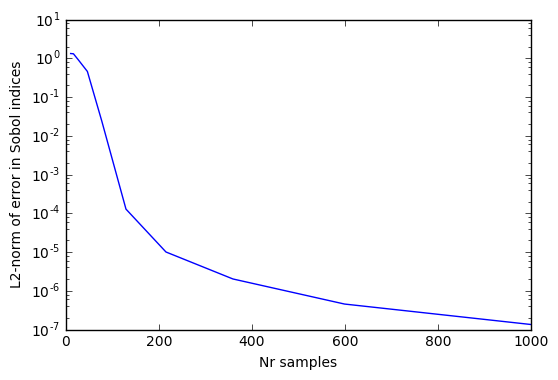

In [21]:
# Polychaos convergence
Npc_list=np.logspace(1,3,10).astype(int)
error=[]
 
for i,Npc in enumerate(Npc_list):
    Zpc=jpdf.sample(Npc)
    Ypc=linear_model(w, Zpc, Npc)
    Npol=4
    poly = cp.orth_chol(Npol, jpdf)
    approx = cp.fit_regression(poly, Zpc, Ypc, rule="T")
    s_pc= cp.Sens_m(approx,jpdf)
    error.append(LA.norm((s_pc-s**2)/s**2))
 
plt.figure()
plt.semilogy(Npc_list,error)
plt.xlabel('Nr samples')
plt.ylabel('L2-norm of error in Sobol indices')

# Conditional variances

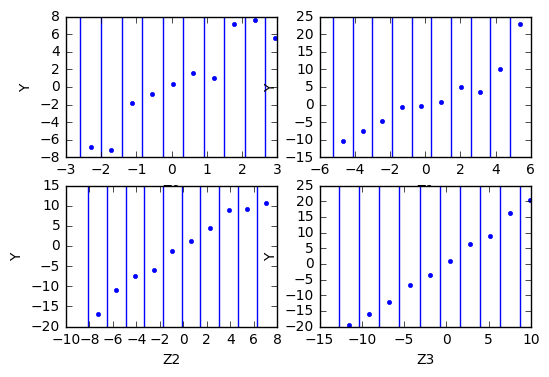

In [22]:
# Scatter plots of averaged data
Zsorted =np.zeros_like(Z)
Ysorted =np.zeros_like(Z)

plt.figure()
plt.title('Slices')
# sort data
for k in range(r):
    plt.subplot(2,2,k+1)
    sidx = np.argsort(Z[k,:])
    Zsorted[k,:]=Z[k,sidx].copy()   
    Ysorted[k,:]=Y[sidx].copy()   

# average data
# slice and plot


# slice data
Ndz=10

Zslice = np.zeros((r,Ndz))
Yslice = np.zeros((r,Ndz))
ZBndry = np.zeros((r,Ndz+1))

dz=np.zeros(r)
for k in range(r):
    dz[k] = (np.max(Zsorted[k,:] - np.min(Zsorted[k,:])) )/Ndz
    
    ZBndry[k,:] = np.linspace(np.min(Zsorted[k,:]),np.max(Zsorted[k,:]), Ndz+1)
    Zslice[k,:] = np.linspace(np.min(Zsorted[k,:])+dz[k]/2.,np.max(Zsorted[k,:])-dz[k]/2., Ndz)
                                          
    for i in range(Ndz):
        zidx_range=np.logical_and(Zsorted[k,:]>=ZBndry[k,i],Zsorted[k,:]<ZBndry[k,i+1])
        
                    
        if np.any(zidx_range):    #check if range has elements
            Yslice[k,i]=np.mean(Ysorted[k,zidx_range])
        else:                     #set value to None if noe elements in z-slice
            Yslice[k,i]=None
    

#print np.argwhere(np.isnan(Zslice))            
#print Zslice
#print Yslice


for k in range(r):
    plt.subplot(2,2,k+1)
        
    for i in range(Ndz):
        plt.axvline(ZBndry[k,i], np.amin(Y), np.amax(Y))        

    plt.plot(Zslice[k,:],Yslice[k,:],'.')
    xlbl='Z'+str(k)
    plt.xlabel(xlbl)
    plt.ylabel('Y')
    
    # true linear model
    Nlin=10
    zmin=np.min(Zslice[k,:]); zmax=np.max(Zslice[k,:])
    zvals=np.linspace(zmin,zmax,Nlin)
    yvals=linear_model(w[k],zvals,Nlin)
#    plt.plot(zvals,yvals)
#    plt.ylim([np.amin(Yslice),np.amax(Yslice)])
#     plt.xlim([np.amin(Z),np.amax(Z)])
#    plt.ylim([-25,15])

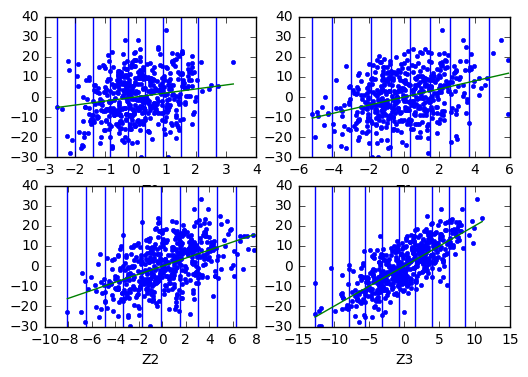

In [23]:
# # Scatter plots of data and regression lines 
plt.figure()
for k in range(r):
    plt.subplot(2,2,k+1)
    
    for i in range(Ndz):
        plt.axvline(ZBndry[k,i], np.amin(Y), np.amax(Y))        

    zmin=np.min(Z[k,:])
    zmax=np.max(Z[k,:])
    zvals=np.linspace(zmin,zmax,N)
    yvals=linear_model(w[k],zvals,N)
    plt.plot(Z[k,:],Y[:],'.',zvals,yvals)
    xlbl='Z'+str(k)
    plt.xlabel(xlbl)

# References

 1. <div id="saltelli_global_2008"></div> **A. (Andrea) Saltelli**. 
    *Global Sensitivity Analysis : the Primer*,
    John Wiley,,
    2008.